# **5장. 합성곱 신경망 1**

**5.1.2 합성곱 신경망 구조**

: **입력층**에서 입력받은 데이터가 **합성곱층**과 **풀링층**을 거치면서 입력 이미지의 주요 특성 벡터가 추출되고, 추출된 주요 특성 벡터들은 **완전연결층**을 거치며 1차원 벡터로 변환되며, **출력층**에서 활성화함수인 소프트멕스 함수를 사용하여 최종 결과가 출력됨

**5.1.3 1D, 2D, 3D 합성곱**

1. 1D 합성곱 : 1차원 입력 + 1차원 필터(좌우 움직임) = 1차원 출력

2. 2D 합성곱 : 2차원 입력(W,H) + 2차원 필터(k,k) = 2차원 출력

3. 3D 합성곱 : 3차원 입력(W, H, L) + 3차원 필터(k,k,d) = 3차원 출력 (d<L)

4. 3D 입력을 갖는 2D 합성곱 : 3차원 입력(W, H, L) + 3차원 필터(k, k, L) = 2차원 출력(d=L)

5. 1x1 합성곱 : 3차원 입력(W, H, L) + 3차원 필터(1, 1, L) = 2차원 출력(W, H)



In [1]:
#라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
#CPU or GPU 장치 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/pytorch_ex/chap05', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('/content/drive/MyDrive/pytorch_ex/chap05', download=True, train=False,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
#fashionMNIST를 다운받을 위치 / <-위치에 해당 데이터셋이 있는지 확인 후 내려받음 / 이미지를 텐서(0~1)로 변경

In [4]:
#데이터를 데이터로더에 전달(내려받은 데이터를 메모리로 불러오기 위해)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100) #100개 단위로 데이터를 배치로 묶어서 불러옴
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [5]:
print(len(train_dataset))
print(train_dataset[0][1]) #tensor(n차원 특성 가진 텐서, 레이블 숫자)

60000
9


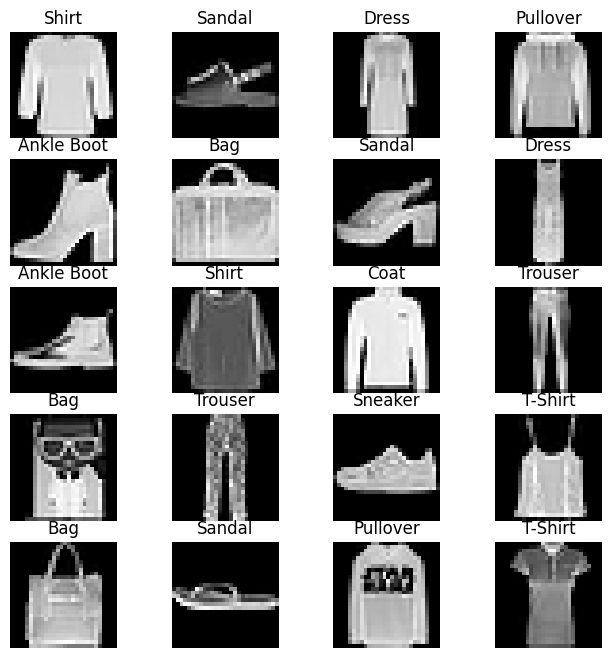

In [6]:
#분류에 사용될 클래스 정의
labels_map = {   0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'   }

fig = plt.figure(figsize=(8,8)) ; #출력할 이미지의 가로세로 크기(단위: 인치)
columns = 4 ; #그림 4열 출력
rows = 5 ; #그림 5행 출력
for i in range(1, columns*rows + 1) : #열*행만큼의 그림
  img_xy = np.random.randint( len(train_dataset) ) ; #랜덤 샘플 1개 인덱스
  img = train_dataset[img_xy][0][0,:,:] #??
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() #20개의 이미지 데이터를 시각적으로 표현

In [7]:
#심층 신경망 모델 생성

class FashionDNN(nn.Module) :
  def __init__(self) :
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256) #1차 은닉층 구현
    self.drop = nn.Dropout(0.25) #드롭아웃 구현(과적합 막음)
    self.fc2 = nn.Linear(in_features=256, out_features=128) #2차 은닉층 구현
    self.fc3 = nn.Linear(in_features=128, out_features=10) #출력층 구현

  def forward(self, input_data) :
    out = input_data.view(-1, 784) #텐서 모양 재구성 -> self.fc1에 들어갈 수 있게 (파이토치의 .view는 넘파이의 .reshape와 같은 역할)
    out = F.relu( self.fc1(out) )
    out = self.drop( out )
    out = F.relu( self.fc2(out) ) #F.relu(): foward() 함수에서 사용 / nn.ReLU(): __init__() 함수에서 정의
    out = self.fc3( out )
    return out

In [8]:
#심층 신경망에 필요한 파라미터 정의
learning_rate = 0.001 ;
model = FashionDNN() ;
model.to(device)

criterion = nn.CrossEntropyLoss() ; #크로스 엔트로피(다중 분류 손실함수)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) ;
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
#심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = [] #손실 누적
iteration_list = [] #반복 누적
accuracy_list = [] #정확도 누적

predictions_list = [] #예측값 누적
labels_list = []


for epoch in range(num_epochs) :
  for images, labels in train_loader :
    images, labels = images.to(device), labels.to(device)

    train = Variable( images.view(100, 1, 28, 28) )
    labels = Variable(labels)

    outputs = model(train) #훈련 세트를 모델에 적용
    loss = criterion(outputs, labels) #손실함수(크로스 엔트로피)
    optimizer.zero_grad() #가중치 0으로 초기화
    loss.backward() #역전파
    optimizer.step()
    count += 1

    if not (count % 50) : #count를 50으로 나눈 나머지가 0이 아니라면
      total = 0
      correct = 0
      for images, labels in test_loader : #테스트 세트
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable( images.view(100, 1, 28, 28) )
        outputs = model(test) #테스트 세트를 신경망에 넣어 출력
        predictions = torch.max(outputs, 1)[1].to(device) #테스트 세트의 예측값
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total

      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500) :
      print(f'Iteration: {count}, Accuracy: {accuracy}, Loss: {loss.data}')

Iteration: 500, Accuracy: 83.08000183105469, Loss: 0.575937032699585
Iteration: 1000, Accuracy: 84.41000366210938, Loss: 0.4863338768482208
Iteration: 1500, Accuracy: 84.43000030517578, Loss: 0.40643757581710815
Iteration: 2000, Accuracy: 85.80999755859375, Loss: 0.3679588735103607
Iteration: 2500, Accuracy: 86.2300033569336, Loss: 0.26968345046043396
Iteration: 3000, Accuracy: 86.70999908447266, Loss: 0.2684730291366577


In [10]:
#합성곱 신경망 생성

class FashionCNN(nn.Module) :

  def __init__(self) :
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #합성곱층
        nn.BatchNorm2d(32), #정규화(가우시안 형태로~)
        nn.ReLU(), #렐루 활성화 함수
        nn.MaxPool2d(kernel_size=2, stride=2) #최대 풀링
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), #합성곱층 1번 더
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x) :
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1) #완전연결층에 들어가기 위해 재배치(일자로 펼침)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [11]:
#합성곱 신경망을 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
#합성곱 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = [] #손실 누적
iteration_list = [] #반복 누적
accuracy_list = [] #정확도 누적

predictions_list = [] #예측값 누적
labels_list = []


for epoch in range(num_epochs) :
  for images, labels in train_loader :
    images, labels = images.to(device), labels.to(device)

    train = Variable( images.view(100, 1, 28, 28) )
    labels = Variable(labels)

    outputs = model(train) #훈련 세트를 모델에 적용
    loss = criterion(outputs, labels) #손실함수(크로스 엔트로피)
    optimizer.zero_grad() #가중치 0으로 초기화
    loss.backward() #역전파
    optimizer.step()
    count += 1

    if not (count % 50) : #count를 50으로 나눈 나머지가 0이 아니라면
      total = 0
      correct = 0
      for images, labels in test_loader : #테스트 세트
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable( images.view(100, 1, 28, 28) )
        outputs = model(test) #테스트 세트를 신경망에 넣어 출력
        predictions = torch.max(outputs, 1)[1].to(device) #테스트 세트의 예측값
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total

      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500) :
      print(f'Iteration: {count}, Accuracy: {accuracy}, Loss: {loss.data}')

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Accuracy: 87.83999633789062, Loss: 0.4834580719470978
Iteration: 1000, Accuracy: 87.38999938964844, Loss: 0.36455172300338745
Iteration: 1500, Accuracy: 88.08000183105469, Loss: 0.3553614914417267
Iteration: 2000, Accuracy: 89.04000091552734, Loss: 0.20099413394927979
Iteration: 2500, Accuracy: 89.30000305175781, Loss: 0.11200598627328873
Iteration: 3000, Accuracy: 90.05999755859375, Loss: 0.15887777507305145


# 5.3 전이 학습 (Transfer Learning)

: 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와서, 우리가 해결하려는 과제에 맞게 보정하여 사용하는 것

---



**5.3.1 특성 추출 (Feature Extrator)**

: ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후, 마지막에 **완전연결층 부분만** 새로 만듦

- 구성

    - 합성곱층: 합성곱층과 풀링층으로 구성
    - 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지의 클래스 분류
- 데이터 분류기만 새로 학습 (합성곱층은 가중치 고정)

In [13]:
pip install opencv-python

In [14]:
#라이브러리 호출

import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms #데이터 전처리 패키지
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [15]:
#이미지 데이터의 전처리 방법 정의

data_path = '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize( [256,256] ), #이미지 크기 256x256으로 조정
        transforms.RandomResizedCrop(224), #이미지를 랜덤한 비율로 자르고 데이터 크기 조정
        transforms.RandomHorizontalFlip(), #이미지를 랜덤하게 수평으로 뒤집음
        transforms.ToTensor() #이미지 데이터를 텐서로 변환
    ]
)

train_dataset = torchvision.datasets.ImageFolder( data_path, transform = transform )
#데이터로더가 데이터를 불러올 대상(or 경로) / 방법(or 전처리) 정의해줌

train_loader = torch.utils.data.DataLoader(   train_dataset, batch_size=32, num_workers=8, shuffle=True   )
#num_workers: 데이터를 불러올 때 하위 프로세스 몇 개 사용할지 //  shuffle: 데이터 무작위로 섞어서 불러올지

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [17]:
pip install --user mxnet

In [18]:
#사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True) #pretrain: 사전 학습된 가중치를 사용하겠단 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.4MB/s]


In [19]:
#사전 훈련된 모델의 파라미터 학습 유무 지정

def set_parameter_requires_grad(model, feature_extracting=True) :
  if feature_extracting :
    for param in model.parameters() :
      param.requires_grad=False #역전파 중 파라미터들에 대한 변화 계산할 필요 없음 (합성곱층은 가중치 고정)

set_parameter_requires_grad(resnet18)

In [20]:
#ResNet18에 완전연결층 추가

resnet18.fc = nn.Linear(512, 2)

In [21]:
#모델의 파라미터 값 확인

for name, param in resnet18.named_parameters() : #model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
  if param.requires_grad :
    print(name, param.data)

fc.weight tensor([[-0.0096, -0.0204,  0.0304,  ...,  0.0420,  0.0371,  0.0321],
        [ 0.0277, -0.0411,  0.0324,  ...,  0.0404, -0.0117,  0.0137]])
fc.bias tensor([ 0.0130, -0.0309])


In [22]:
#모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)

for param in model.parameters() :
  param.requires_grad = False #합성곱층 - 가중치 고정

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters() :
  param.requires_grad = True #완전연결층 - 가중치 학습

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
#모델 학습을 위한 함수 생성

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True) :
  since = time.time() #컴퓨터의 현재 시각 구하는 함수
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs) :
    print(f'Epoch {epoch}/{num_epochs-1}') #n번째/전체 에포크
    print('-'*10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders :
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad() #가중치 0으로 초기화
      outputs = model(inputs) #순전파 계산
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders.dataset) #평균 오차 계산
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    print(f'loss: {epoch_loss:.4f}  acc: {epoch_acc:.4f}')

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog',
                                                '{0:0=2d}.pth'.format(epoch))) #모델 재사용 위해 저장해둠

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s')
  print(f'Best Acc: {best_acc:4f}')

  return acc_history, loss_history

In [24]:
#파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []

for name, param in resnet18.named_parameters() :
  if param.requires_grad == True :
    params_to_update.append(param)
    print('\t', name)

optimizer = optim.Adam(params_to_update) #완전연결층의 어떤 파라미터들이 옵티마이저로 전달되었는지를 보여줌
#(가중치와 절편이 업데이트되고 옵티마이저에 전달됨)

	 fc.weight
	 fc.bias


In [25]:
#모델 학습

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_history, train_loss_history = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
loss: 0.7194  acc: 0.5636

Epoch 1/12
----------
loss: 0.4625  acc: 0.7922

Epoch 2/12
----------
loss: 0.3251  acc: 0.8857

Epoch 3/12
----------
loss: 0.2915  acc: 0.8883

Epoch 4/12
----------
loss: 0.2504  acc: 0.9247

Epoch 5/12
----------
loss: 0.2211  acc: 0.9273

Epoch 6/12
----------
loss: 0.2435  acc: 0.9013

Epoch 7/12
----------
loss: 0.2439  acc: 0.8753

Epoch 8/12
----------
loss: 0.2678  acc: 0.8831

Epoch 9/12
----------
loss: 0.2740  acc: 0.8649

Epoch 10/12
----------
loss: 0.2691  acc: 0.8883

Epoch 11/12
----------
loss: 0.1933  acc: 0.9377

Epoch 12/12
----------
loss: 0.1928  acc: 0.9143

Training complete in  11m  22s
Best Acc: 0.937662


In [26]:
#테스트 세트 호출 및 전처리

test_path = '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/test' #테스트 세트 파일 경로

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)

test_dataset = torchvision.datasets.ImageFolder( root=test_path, transform=transform )

test_loader = torch.utils.data.DataLoader( test_dataset, batch_size=32, num_workers=1, shuffle=True )

print(len(test_dataset))

98


In [27]:
#테스트셋 평가 함수 생성

def eval_model(model, dataloaders, device) :
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/' + '*.pth') #앞 경로에서 pth확장자 갖는 파일 가져옴
  saved_models.sort()
  print('saved_model', saved_models)

  for model_path in saved_models :
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders :
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad() :
        outputs = model(inputs)

      _, preds = torch.max(outputs.data, 1)
      preds[preds >= 0.5] = 1 #출력된 값이 0.5 이상일 시 올바르게 예측
      preds[preds < 0.5] = 0 #출력된 값이 0.5 미만일 시 잘못된 예측
      running_corrects += preds.eq(labels).int().sum() #pred.eq(labels): pred배열과 labels가 일치하는지 검사

    epoch_acc = running_corrects.double() / len(dataloaders.dataset) #테스트 세트의 정확도 계산
    print(f'acc: {epoch_acc:.4f}')

    if epoch_acc > best_acc :
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    print()

  time_elapsed = time.time() - since
  print(f'Validation complete in {time_elapsed // 60 : .0f}m {time_elapsed % 60 : .0f}s')
  print(f'Best Acc: {best_acc:4f}')

  return acc_history

In [28]:
#테스트세트를 평가 함수에 적용

val_acc_history = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/00.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/01.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/02.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/03.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/04.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/05.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/06.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/07.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/08.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/09.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/10.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/11.pth', '/content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/12.pth']
Loading model /content/drive/MyDrive/pytorch_ex/chap05/data/catanddog/00.pth
acc: 0.8673

Loading model /content/drive/MyDrive/py

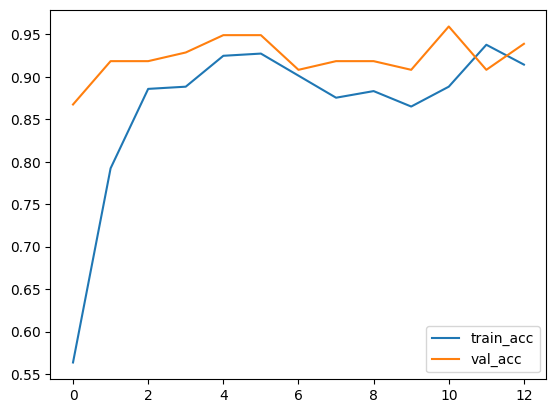

In [29]:
#훈련 세트와 데이터세트의 정확도 그래프

plt.plot(train_acc_history, label='train_acc')
plt.plot(val_acc_history, label='val_acc')
plt.legend()
plt.show()

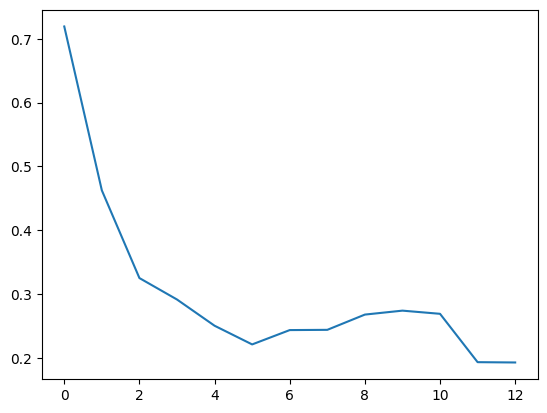

In [30]:
#오차 그래프

plt.plot(train_loss_history)
plt.show()

**5.3.2 미세 조정 기법**

: 사전 훈련된 네트워크를 미세 조정하여, 분석하려는 데이터셋에 잘 맞도록 모델의 파라미터를 조정하는 기법

- 특성 추출과 다르게, 사전 훈련된 모델과 합성곱층의 가중치도 업데이트하여 훈련시킴
- 미세 조정 기법의 전략
    1. 데이터셋이 크고 / 사전 훈련된 모델과 유사성이 작을 경우

    : 모델 전체 재학습

    2. 데이터셋이 크고 / 사전 훈련된 모델과 유사성이 클 경우

    : 합성곱층의 뒷부분, 데이터 분류기 재학습

    3. 데이터셋이 작고 / 사전 훈련된 모델과 유사성이 클 경우

    : 데이터 분류기만 재학습

    4. 데이터셋이 작고 / 사전 훈련된 모델과 유사성이 작을 경우

    : 재학습 범위 적당히 설정 필요

# 5.4 설명 가능한 CNN

: CNN은 내부에서 어떻게 동작하는지 설명이 어렵기 때문에, CNN의 결과를 신뢰하기 위하여 CNN 처리 과정을 시각화할 필요성이 있음

In [31]:
pip install pillow

In [32]:
#특성 맵(입력->필터->특성맵) 시각화 예제

#1. 필요한 라이브러리 호출

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
#2. 설명 가능한 모델을 위해 13개의 합성곱층, 두 개의 완전연결층으로 구성된 네트워크 생성

class XAI(torch.nn.Module) :

  def __init__(self, num_classes=2) :
    super(XAI, self).__init__()
    self.features = nn.Sequential(
        #0
        nn.Conv2d(3, 64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        #1
        nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #2
        nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        #3
        nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #4
        nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        #5
        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        #6
        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #7
        nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        #8
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        #9
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #10
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        #11
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        #12
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self. classifier = nn.Sequential(
        nn.Linear(512, 512, bias=False),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

  def forward(self, x) :
    x = self.features(x)
    x = x.view(-1, 512)
    x = self.classifier(x)
    return F.log_softmax(x)

In [62]:
#3. 모델 객체화

model = XAI() #model이라는 이름의 객체 생성
model.to(device) #연산장치 할당
model.eval() #테스트 데이터에 대한 모델 평가 용도로 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [63]:
#4. 특성 맵을 확인하기 위한 클래스 정의

class LayerActivations :

  features = []
  def __init__(self, model, layer_num) :
    self.hook = model[layer_num].register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output) :
    self.features = output.detach().numpy()

  def remove(self) :
    self.hook.remove()

torch.Size([1, 3, 100, 100])


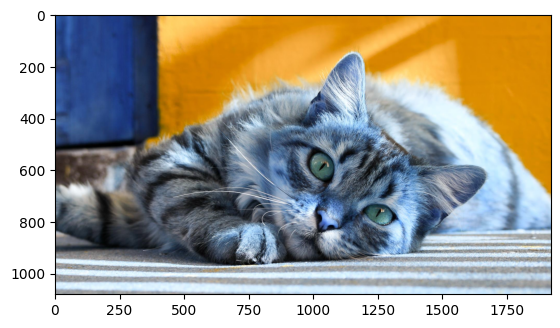

In [64]:
#5. 특성맵 정보 가져올 이미지 호출

img = cv2.imread('/content/drive/MyDrive/pytorch_ex/chap05/data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img, (100,100), interpolation=cv2.INTER_LINEAR) #이미지 크기 변경 / interpolation=보간법 종류
img = transforms.ToTensor()(img).unsqueeze(0) #이미지 데이터 -> 텐서로 변환 -> 1차원 추가

print(img.shape)

In [65]:
#6. (0): Conv2d 특성 맵 확인

result = LayerActivations(model.features, 0) #0번째 합성곱층 특성 맵 확인

model(img)
activations = result.features

<ipython-input-61-092b049b5e64>:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


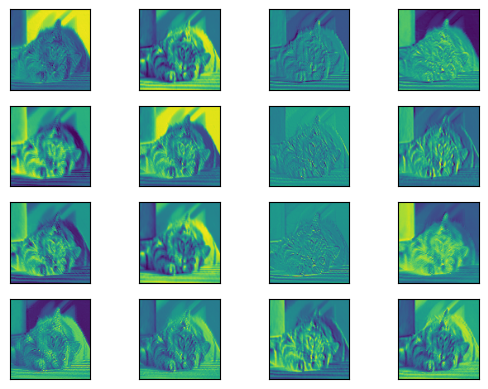

<Figure size 1200x800 with 0 Axes>

In [69]:
#7. 0번째 합성곱층의 특성 맵 시각화

fig, axes = plt.subplots(4,4) #총 화면(fig)을 (4,4)로 나누어 각각 그래프 1개(axes)씩 그림
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4) :
  for column in range(4) :
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([]) #x축 눈금 설정
    axis.get_yaxis().set_ticks([]) #y축 눈금 설정
    axis.imshow(activations[0][row*10 + column])

plt.show()

<ipython-input-61-092b049b5e64>:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


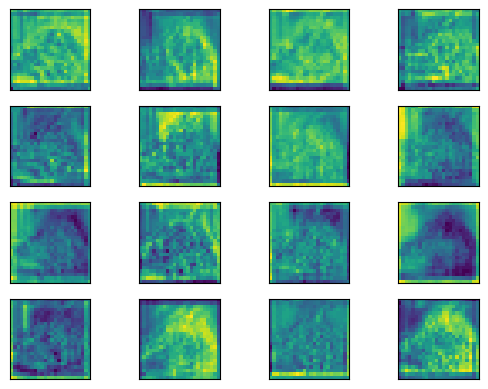

<Figure size 1200x800 with 0 Axes>

In [71]:
#8. 20번째 계층에 대한 특성맵

result = LayerActivations(model.features, 20)

model(img)
activations = result.features


#시각화
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4) :
  for column in range(4) :
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10 + column])

plt.show()

<ipython-input-61-092b049b5e64>:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


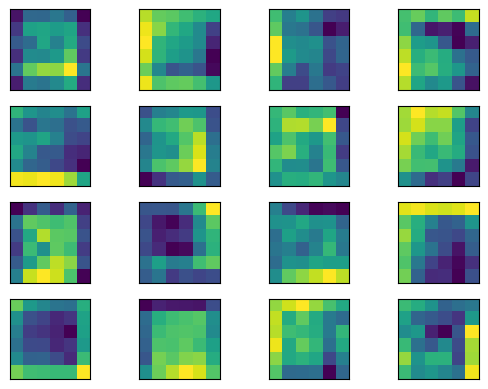

<Figure size 1200x800 with 0 Axes>

In [74]:
#8. 40번째 계층에 대한 특성맵

result = LayerActivations(model.features, 40)

model(img)
activations = result.features


#시각화
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4) :
  for column in range(4) :
    axis = axes[row][column]
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])
    axis.imshow(activations[0][row*10 + column])

plt.show()

#즉, 출력층에 가까울수록 원래 형태는 찾아볼 수 없고, 이미지 특징들만 전달되는 것을 확인할 수 있음